Upload the Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FinancialMarketData.csv to FinancialMarketData (1).csv


Load the Dataset

In [11]:
import pandas as pd

# Load the CSV file
data = pd.read_csv('FinancialMarketData.csv', header=5, skiprows=[6])

# Drop the first two columns, indices 0 and 1
data.drop(data.columns[[0, 1]], axis=1, inplace=True)

# Rename incorrectly named column
data.rename(columns={
    'Ticker': 'Date',
    'VIX Index': 'VIX',
    'BDIY Index': 'BDIY',
    'DXY Curncy': 'DXY',
    'USGG30YR Index': 'USGG30YR',
    'GT10 Govt': 'GT10',
    'GTDEM10Y Govt': 'GTDEM10Y'
  }, inplace=True)

# Convert and Set Date Column
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

print(data.columns)

# Define Crash Threshold and Create Column
# Define a crash as VIX exceeding a threshold (example: VIX > 40)
data['Crash'] = data['VIX'].apply(lambda x: 1 if x > 40 else 0)


# Update Feature Selection
selected_columns = ['VIX', 'BDIY', 'DXY', 'USGG30YR', 'GT10', 'GTDEM10Y', 'Crash']
data = data[selected_columns]



Index(['XAU BGNL Curncy', 'ECSURPUS Index', 'BDIY', 'CRY Index', 'DXY',
       'JPY Curncy', 'GBP Curncy', 'Cl1 Comdty', 'VIX', 'USGG30YR', 'GT10',
       'USGG2YR Index', 'USGG3M Index', 'US0001M Index', 'GTDEM30Y Govt',
       'GTDEM10Y', 'GTDEM2Y Govt', 'EONIA Index', 'GTITL30YR Corp',
       'GTITL10YR Corp', 'GTITL2YR Corp', 'GTJPY30YR Corp', 'GTJPY10YR Corp',
       'GTJPY2YR Corp', 'GTGBP30Y Govt', 'GTGBP20Y Govt', 'GTGBP2Y Govt',
       'LUMSTRUU Index', 'LMBITR Index', 'LUACTRUU Index', 'LF98TRUU Index',
       'LG30TRUU Index', 'LP01TREU Index', 'EMUSTRUU Index', 'LF94TRUU Index',
       'MXUS Index', 'MXEU Index', 'MXJP Index', 'MXBR Index', 'MXRU Index',
       'MXIN Index', 'MXCN Index', 'MXWO Index', 'MXWD Index',
       'LEGATRUU Index', 'HFRXGL Index', 'RX1 Comdty', 'TY1 Comdty',
       'GC1 Comdty', 'CO1 Comdty', 'ES1 Index', 'VG1 Index', 'NQ1 Index',
       'LLL1 Index', 'TP1 Index', 'DU1 Comdty', 'TU2 Comdty'],
      dtype='object')


Exploratory Data Analysis

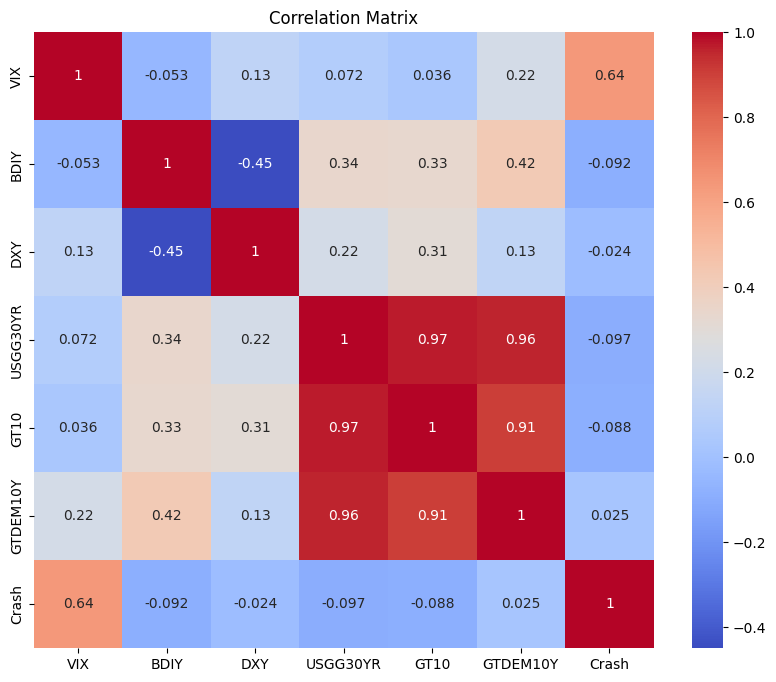

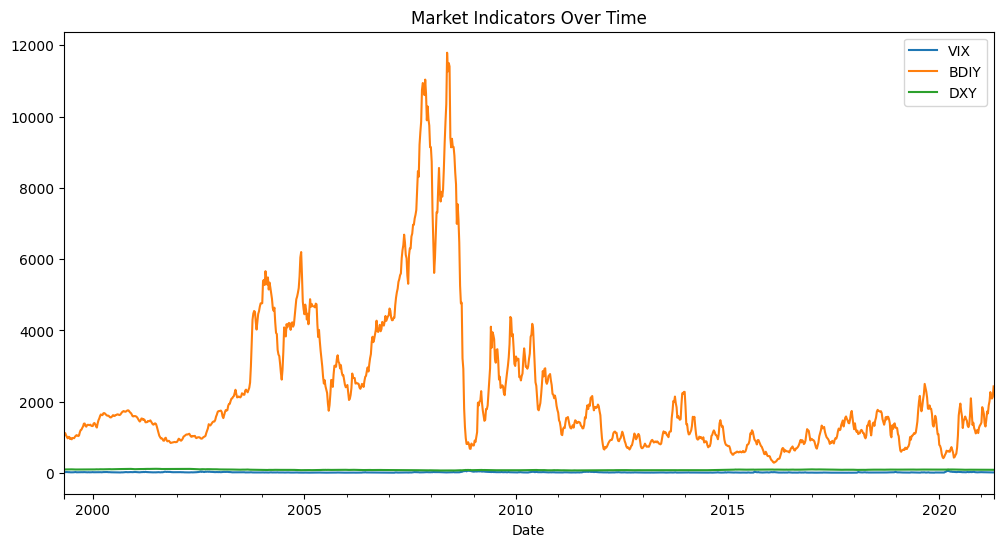

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Plot time series
data[['VIX', 'BDIY', 'DXY']].plot(figsize=(12, 6))
plt.title("Market Indicators Over Time")
plt.show()

Feature Engineering

In [14]:
data['VIX_RollingMean'] = data['VIX'].rolling(window=30).mean()
data['BDIY_PercentChange'] = data['BDIY'].pct_change()

Data Splitting

In [16]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Crash'])
y = data['Crash']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

# impute missing values with mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[336   1]
 [  2   6]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       337
           1       0.86      0.75      0.80         8

    accuracy                           0.99       345
   macro avg       0.93      0.87      0.90       345
weighted avg       0.99      0.99      0.99       345



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Isolation Forest

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


Anomaly Detection Results:
Number of anomalies detected: 45


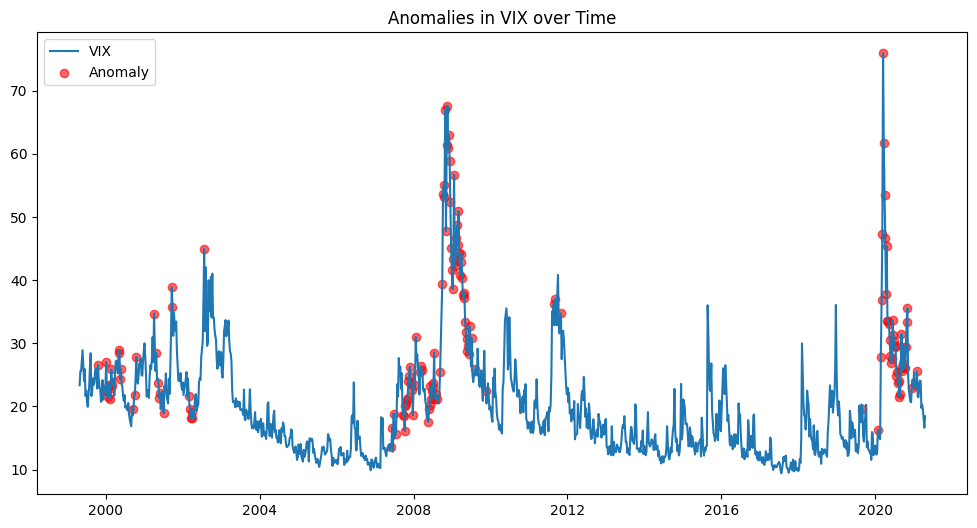

In [19]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Fit the model on the data (using only features, no target variable)
iso_forest.fit(X_train)

# Predict anomalies (1 for normal, -1 for anomaly)
y_pred_anomalies = iso_forest.predict(X_test)

# Convert the predicted values to binary (0 for normal, 1 for anomaly)
y_pred_anomalies = [1 if x == -1 else 0 for x in y_pred_anomalies]

# Add anomaly prediction as a new column in the dataframe
data['Anomaly'] = [1 if x == -1 else 0 for x in iso_forest.predict(X)]

# Evaluate the anomaly detection results
print("Anomaly Detection Results:")
print("Number of anomalies detected:", sum(y_pred_anomalies))

# Visualize the anomalies in the time series (for example, with VIX as an indicator)
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['VIX'], label='VIX')
plt.scatter(data.index[data['Anomaly'] == 1], data['VIX'][data['Anomaly'] == 1], color='red', label='Anomaly', alpha=0.6)
plt.title("Anomalies in VIX over Time")
plt.legend()
plt.show()


Streamlit App

In [20]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.2 MB/s eta 0:00:00


In [22]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix

# Load the CSV file
@st.cache
def load_data():
    data = pd.read_csv('FinancialMarketData.csv', header=5, skiprows=[6])
    data.drop(data.columns[[0, 1]], axis=1, inplace=True)
    data.rename(columns={'Ticker': 'Date', 'VIX Index': 'VIX', 'BDIY Index': 'BDIY', 'DXY Curncy': 'DXY', 'USGG30YR Index': 'USGG30YR', 'GT10 Govt': 'GT10', 'GTDEM10Y Govt': 'GTDEM10Y'}, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data['Crash'] = data['VIX'].apply(lambda x: 1 if x > 40 else 0)
    selected_columns = ['VIX', 'BDIY', 'DXY', 'USGG30YR', 'GT10', 'GTDEM10Y', 'Crash']
    data = data[selected_columns]
    return data

# Load data
data = load_data()

# Display the data in the app
st.title("Financial Market Dashboard")
st.subheader("Market Data Overview")
st.write(data.head())

# Create a correlation matrix heatmap
st.subheader("Correlation Matrix")
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', ax=ax)
st.pyplot(fig)

# Time series plot of VIX, BDIY, and DXY
st.subheader("Market Indicators Over Time")
fig, ax = plt.subplots(figsize=(12, 6))
data[['VIX', 'BDIY', 'DXY']].plot(ax=ax)
st.pyplot(fig)

# Model: Logistic Regression for Crash Prediction
st.subheader("Crash Prediction Model")

# Prepare data for training
X = data.drop(columns=['Crash'])
y = data['Crash']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Fit the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
st.write("Confusion Matrix:")
st.write(confusion_matrix(y_test, y_pred))
st.write("Classification Report:")
st.write(classification_report(y_test, y_pred))


Overwriting app.py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [23]:
streamlit run app.py

SyntaxError: invalid syntax (<ipython-input-23-718866ff34b9>, line 1)